<center>Age and Gender Prediction</center>


The <a href="https://susanqq.github.io/UTKFace/"> UTKFace dataset </a> is a large-scale faces dataset consisting of over 20,000 images. The images cover a wide range of ages and races and include both males and females. 

Using this dataset, I will be attempting to create a model capable of predicting the age and gender of an individual.

#Concepts to explore

- Classification task
- Convolutional neural network
- AI ethics and bias
- Model interpretability

#Requirements

- Going through the standard cycle of EDA-model-evaluation.
- Create a single model that returns age and gender in a single pass
- Analyze model performance
- Understand, which are the best/worst performing samples.
- Use LIME for model interpretability with images. Understand what you model

Once done with these tasks, I will also evaluate any ethical issues with this model

- Identify how this model can be biased and check if the results show signs of these issues.
- Analyze bad predictions. Are there any patterns in misclassified samples, that can cause ethical concerns?
- Describe in which scenarios the model can be biased. Propose solutions to mitigate it.
- Think of a domain, where this model could/could-not be deployed.

In [1]:
import os
import random
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import seaborn as sns

BASE_DIR = r'data/utkface_aligned_cropped/UTKFace'

age_labels = []
gender_labels = []
image_paths = []
ethnicity_labels = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

corrupt_files = []
non_rgb_files = []
unique_shapes = set()

for image in tqdm(image_filenames):
    if len(image.split('_')) != 4:
        print(f"Skipping file with unexpected format: {image}")
        continue
    
    image_path = os.path.join(BASE_DIR, image)
    img_components = image.split('_')
    try:
        age_label = int(img_components[0])
        gender_label = int(img_components[1])
        ethnicity_label = int(img_components[2])
    except ValueError:
        print(f"Skipping file with invalid labels: {image}")
        continue

    img = cv2.imread(image_path)
    if img is None:
        print(f"Skipping unreadable/corrupt file: {image_path}")
        corrupt_files.append(image_path)
        continue

    if len(img.shape) != 3 or img.shape[2] != 3:
        print(f"Skipping non-RGB image: {image_path}")
        non_rgb_files.append(image_path)
        continue

    unique_shapes.add(img.shape)

    age_labels.append(age_label)
    gender_labels.append(gender_label)
    ethnicity_labels.append(ethnicity_label)
    image_paths.append(image_path)

age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)
ethnicity_labels = np.array(ethnicity_labels)
image_paths = np.array(image_paths)

print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of ethnicity_labels: {len(ethnicity_labels)}, Number of image_paths: {len(image_paths)}')

print(f'Number of corrupted files: {len(corrupt_files)}')
print(f'Number of non-RGB files: {len(non_rgb_files)}')
print(f'Unique image shapes: {unique_shapes}')

 24%|██▍       | 5787/23708 [00:03<00:11, 1588.99it/s]

Skipping file with unexpected format: 39_1_20170116174525125.jpg.chip.jpg
Skipping file with unexpected format: 61_1_20170109142408075.jpg.chip.jpg


 39%|███▉      | 9315/23708 [00:06<00:10, 1327.07it/s]

Skipping file with unexpected format: 61_1_20170109150557335.jpg.chip.jpg


100%|██████████| 23708/23708 [00:14<00:00, 1612.46it/s]

Number of age_labels: 23705, Number of gender_labels: 23705, Number of ethnicity_labels: 23705, Number of image_paths: 23705
Number of corrupted files: 0
Number of non-RGB files: 0
Unique image shapes: {(200, 200, 3)}


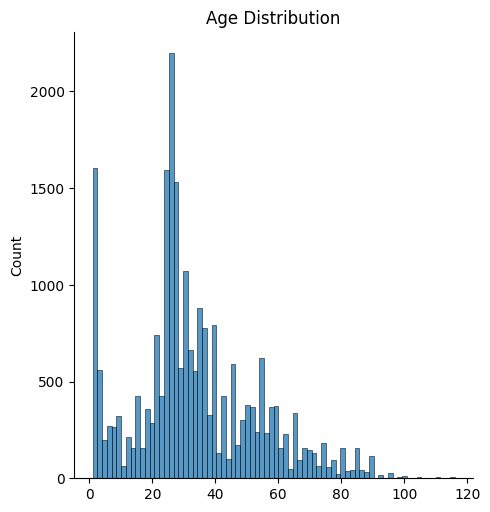

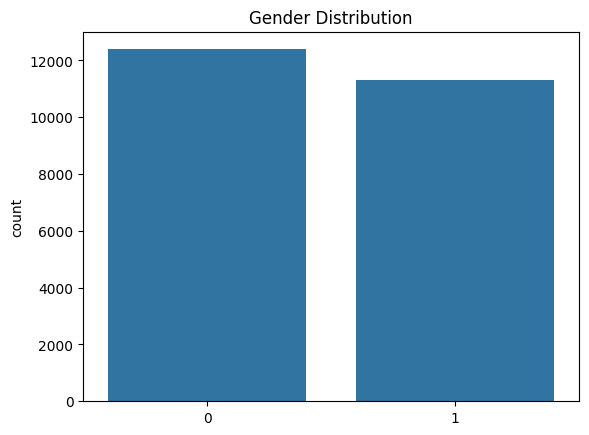

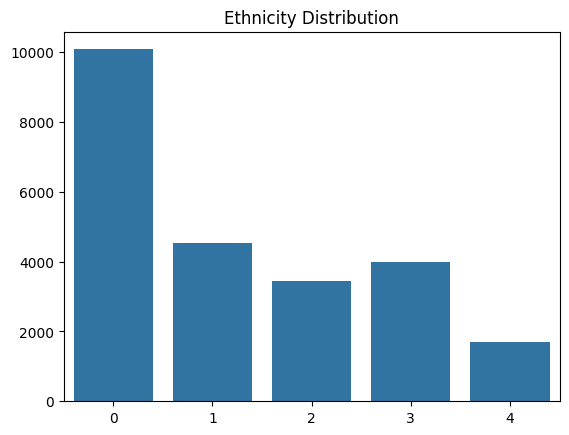

In [2]:
sns.displot(x=age_labels)
plt.title('Age Distribution')
plt.show()

sns.countplot(x=gender_labels)
plt.title('Gender Distribution')
plt.show()

sns.barplot(x=np.unique(ethnicity_labels), y=np.bincount(ethnicity_labels))
plt.title('Ethnicity Distribution')
plt.show()

After these brief observations, we can conclude that:
- the ages distribution is highly skewed to the left, with many ages close to 0 and many ages close to 30
- we have a fair distribution of data over the gender
- we note a majority of data is from White ethnicity.

Due to the high prevalence of data around the 0 age mark, I will proceed by filtering them out to avoid the model fitting too much to this data. 

In [3]:
import pandas as pd

images_data = pd.DataFrame({'image': image_paths, 'age': age_labels, 'gender': gender_labels, 'ethnicity': ethnicity_labels})

images_data

image  age  gender  \
0      data/utkface_aligned_cropped/UTKFace\10_0_0_20...   10       0   
1      data/utkface_aligned_cropped/UTKFace\30_1_2_20...   30       1   
2      data/utkface_aligned_cropped/UTKFace\24_0_4_20...   24       0   
3      data/utkface_aligned_cropped/UTKFace\48_0_1_20...   48       0   
4      data/utkface_aligned_cropped/UTKFace\58_0_1_20...   58       0   
...                                                  ...  ...     ...   
23700  data/utkface_aligned_cropped/UTKFace\37_1_0_20...   37       1   
23701  data/utkface_aligned_cropped/UTKFace\2_1_2_201...    2       1   
23702  data/utkface_aligned_cropped/UTKFace\35_0_0_20...   35       0   
23703  data/utkface_aligned_cropped/UTKFace\55_1_0_20...   55       1   
23704  data/utkface_aligned_cropped/UTKFace\2_0_2_201...    2       0   

       ethnicity  
0              0  
1              2  
2              4  
3              1  
4              1  
...          ...  
23700          0  
23701          2  
23702          0  
23703          0  
23704          2  

[23705 rows x 4 columns]

In [4]:
print(images_data.info())
print(images_data['age'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      23705 non-null  object
 1   age        23705 non-null  int32 
 2   gender     23705 non-null  int32 
 3   ethnicity  23705 non-null  int32 
dtypes: int32(3), object(1)
memory usage: 463.1+ KB
None
count    23705.000000
mean        33.300907
std         19.885708
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64


The mean age in our dataset is 33 years old, with a standard deviation of 19. Let's see how this changes after removing data with ages too close to 0.

In [5]:
images_data = images_data[images_data['age'] >= 3]

print(images_data.info())
print(images_data['age'].describe())

<class 'pandas.core.frame.DataFrame'>
Index: 22100 entries, 0 to 23703
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      22100 non-null  object
 1   age        22100 non-null  int32 
 2   gender     22100 non-null  int32 
 3   ethnicity  22100 non-null  int32 
dtypes: int32(3), object(1)
memory usage: 604.3+ KB
None
count    22100.000000
mean        35.624932
std         18.557242
min          3.000000
25%         25.000000
50%         30.000000
75%         46.000000
max        116.000000
Name: age, dtype: float64


Great. Let's now visualize some of the images we are going to deal with. 

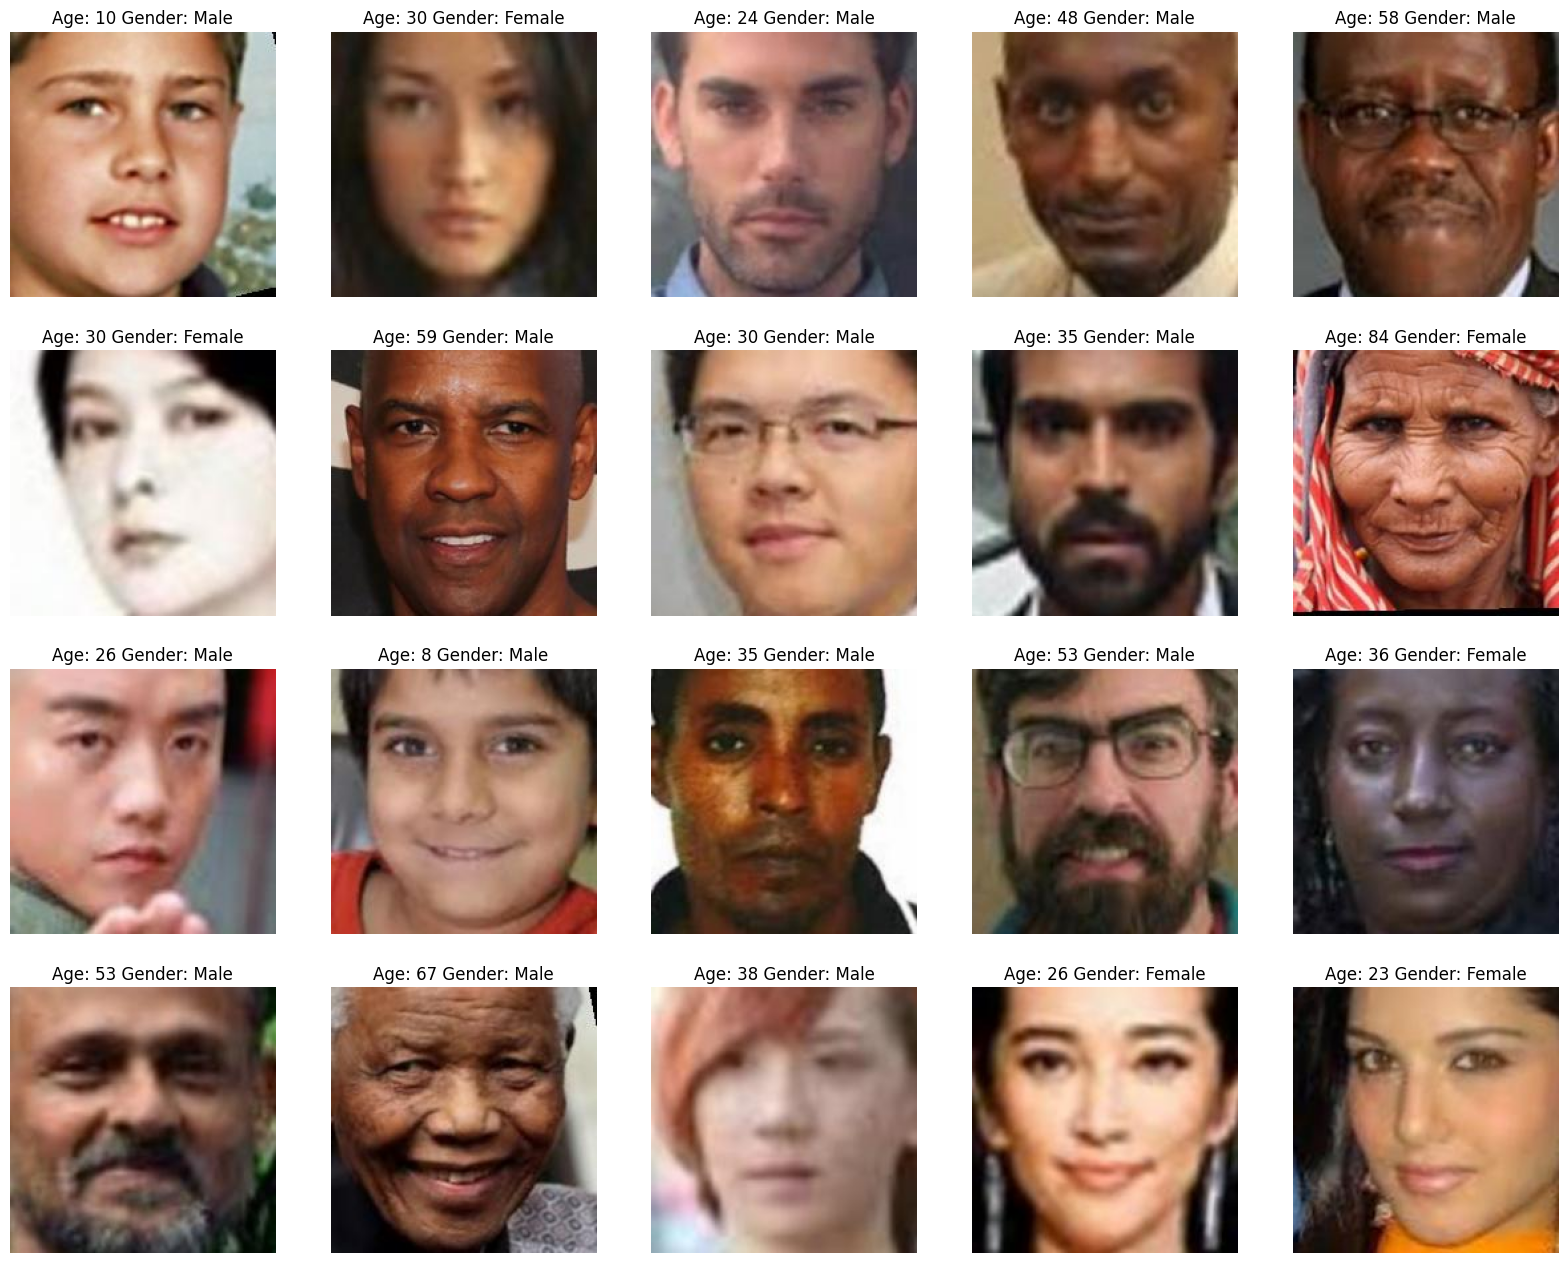

In [6]:
def plot_sample_images(image_paths, age_labels, gender_labels, gender_mapping, num_images=20):
    "Function to display sample images from UTKface dataset"
    plt.figure(figsize=(20, 20))
    
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        img = cv2.imread(image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        age = age_labels[i]
        gender = gender_mapping[gender_labels[i]]
        plt.axis('off')
        plt.title(f'Age: {age} Gender: {gender}')
        plt.imshow(img)

    plt.show()

gender_mapping = {1: 'Female', 0: 'Male'}
ethnicity_mapping = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

plot_sample_images(image_paths, age_labels, gender_labels, gender_mapping, num_images=20)

In [7]:
def get_ethnicity_samples(images_data, ethnicity_id, num_samples=4):
    samples = images_data[images_data['ethnicity'] == ethnicity_id]
    sample_images = samples.head(num_samples)
    return sample_images

ethnicity_samples = {}
for ethnicity_id in range(len(ethnicity_mapping)):
    ethnicity_samples[ethnicity_id] = get_ethnicity_samples(images_data, ethnicity_id)

# Creating a model

Here, we want to go through the process of creating a model that will try to predict:

- Age
- Gender

We will use PyTorch to achieve this result, and we will use the [LIME](https://github.com/marcotcr/lime) library to generate the explanations.

In the code snippet below, we will split the data into training, validation, and testing sets, and create transformers to resize and normalize the images, then moving them to tensors.

In [8]:
train_data, test_data = train_test_split(images_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

class UTKFaceDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        age = self.data.iloc[idx, 1]
        gender = self.data.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)
        
        return image, age, gender

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = UTKFaceDataset(train_data, transform=transform)
val_dataset = UTKFaceDataset(val_data, transform=transform)
test_dataset = UTKFaceDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Now let's create the model

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class AgeGenderCNN(nn.Module):
    def __init__(self):
        super(AgeGenderCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128*16*16, 512)

        self.age_fc2 = nn.Linear(512, 1)
        self.gender_fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        age_output = F.relu(self.age_fc2(x)) 
        gender_output = self.gender_fc2(x)
        
        return age_output, gender_output

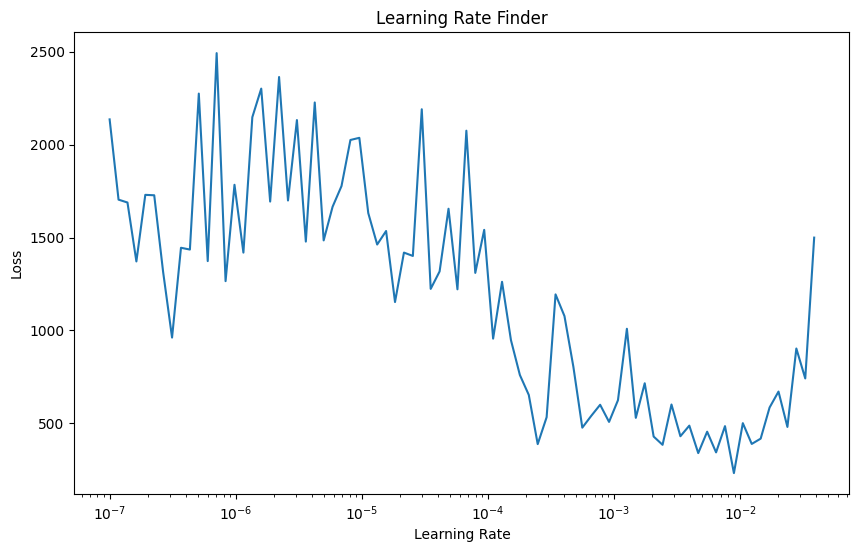

In [15]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.history = {"lr": [], "loss": []}

    def range_test(self, dataloader, start_lr=1e-7, end_lr=1, num_iter=100):
        lrs = np.logspace(np.log10(start_lr), np.log10(end_lr), num_iter)
        initial_state = self.model.state_dict()
        self.model.train()
        best_loss = float('inf')
        running_loss = 0.0

        for i, (images, ages, genders) in enumerate(dataloader):
            if i >= num_iter:
                break
            
            lr = lrs[i]
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

            images = images.to(self.device)
            ages = ages.to(self.device).float()
            genders = genders.to(self.device).long()

            self.optimizer.zero_grad()
            age_outputs, gender_outputs = self.model(images)

            age_loss = self.criterion[0](age_outputs.view(-1), ages)
            gender_loss = self.criterion[1](gender_outputs, genders)
            loss = age_loss + gender_loss

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            self.history["lr"].append(lr)
            self.history["loss"].append(loss.item())

            if loss.item() < best_loss:
                best_loss = loss.item()
            if loss.item() > 4 * best_loss:
                break

            running_loss = 0.0

        self.model.load_state_dict(initial_state)

    # Assuming lr_finder is the instance of LRFinder and has the history data
    def plot(self):
        lrs = self.history['lr']
        losses = self.history['loss']

        plt.figure(figsize=(10, 6))
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Finder')
        plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AgeGenderCNN().to(device)
age_criterion = nn.MSELoss()
gender_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)  # start with a very low learning rate

# Create the learning rate finder and run it
lr_finder = LRFinder(model, optimizer, (age_criterion, gender_criterion), device)
lr_finder.range_test(train_loader, start_lr=1e-7, end_lr=1, num_iter=100)
lr_finder.plot()

Based on this graph, it seems like a reasonable learning rate can be between 1e-4 and 1e-3. This is due to the steep decline at around 1e-4 going down until 1e-3.

In [16]:
optimal_lr = 1e-3

In [17]:
model = AgeGenderCNN().to(device)
age_criterion = nn.MSELoss()
gender_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for param_group in optimizer.param_groups:
    param_group['lr'] = optimal_lr

def train_model(model, age_criterion, gender_criterion, optimizer, dataloader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, ages, genders in dataloader:
            images = images.to(device)
            ages = ages.to(device).float()
            genders = genders.to(device).long()

            optimizer.zero_grad()
            age_outputs, gender_outputs = model(images)

            age_loss = age_criterion(age_outputs.view(-1), ages)
            gender_loss = gender_criterion(gender_outputs, genders)
            loss = age_loss + gender_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

print("Training Age and Gender Prediction Model with optimal learning rate")
train_model(model, age_criterion, gender_criterion, optimizer, train_loader, num_epochs=10)

Training Age and Gender Prediction Model with optimal learning rate
Epoch 1/10, Loss: 296.5370
Epoch 2/10, Loss: 181.5779
Epoch 3/10, Loss: 142.0788
Epoch 4/10, Loss: 113.2662
Epoch 5/10, Loss: 97.6151
Epoch 6/10, Loss: 83.0360
Epoch 7/10, Loss: 73.0280
Epoch 8/10, Loss: 63.0750
Epoch 9/10, Loss: 56.3457
Epoch 10/10, Loss: 47.6925


# Model Evaluation

In [18]:
def evaluate_model(model, age_criterion, gender_criterion, dataloader, plot_predictions=False):
    model.eval()
    running_loss = 0.0
    all_age_outputs = []
    all_gender_outputs = []
    all_age_labels = []
    all_gender_labels = []
    all_images = []
    with torch.no_grad():
        for images, ages, genders in dataloader:
            images = images.to(device)
            ages = ages.to(device).float()
            genders = genders.to(device).long()

            age_outputs, gender_outputs = model(images)

            age_loss = age_criterion(age_outputs.view(-1), ages)
            gender_loss = gender_criterion(gender_outputs, genders)
            loss = age_loss + gender_loss

            age_preds = age_outputs.view(-1).cpu().numpy()
            gender_preds = torch.argmax(gender_outputs, dim=1).cpu().numpy()
            age_labels = ages.cpu().numpy()
            gender_labels = genders.cpu().numpy()

            all_age_outputs.extend(age_preds)
            all_gender_outputs.extend(gender_preds)
            all_age_labels.extend(age_labels)
            all_gender_labels.extend(gender_labels)
            all_images.extend(images.cpu().numpy())

            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Loss: {epoch_loss:.4f}')
    age_mae = np.mean(np.abs(np.array(all_age_outputs) - np.array(all_age_labels)))
    print(f'Age MAE: {age_mae:.4f}')
    gender_accuracy = np.sum(np.array(all_gender_outputs) == np.array(all_gender_labels)) / len(all_gender_labels)
    print(f'Gender Accuracy: {gender_accuracy:.4f}')

    if plot_predictions:
        plot_age_predictions(np.array(all_age_outputs), np.array(all_age_labels))
        plot_gender_predictions(np.array(all_gender_outputs), np.array(all_gender_labels))

    return np.array(all_age_outputs), np.array(all_gender_outputs), np.array(all_age_labels), np.array(all_gender_labels), np.array(all_images)

all_age_outputs, all_gender_outputs, all_age_labels, all_gender_labels, all_images = evaluate_model(model, age_criterion, gender_criterion, test_loader, plot_predictions=False)

Loss: 88.8917
Age MAE: 6.9347
Gender Accuracy: 0.9090


Our results are shown as follows, with a MAE of 6.9 we are not really close to the true age as we might want to be. The Gender accuracy instead is much higher which is quite good.

This means that the model is likely good at predicting the gender, but not at predicting the age.

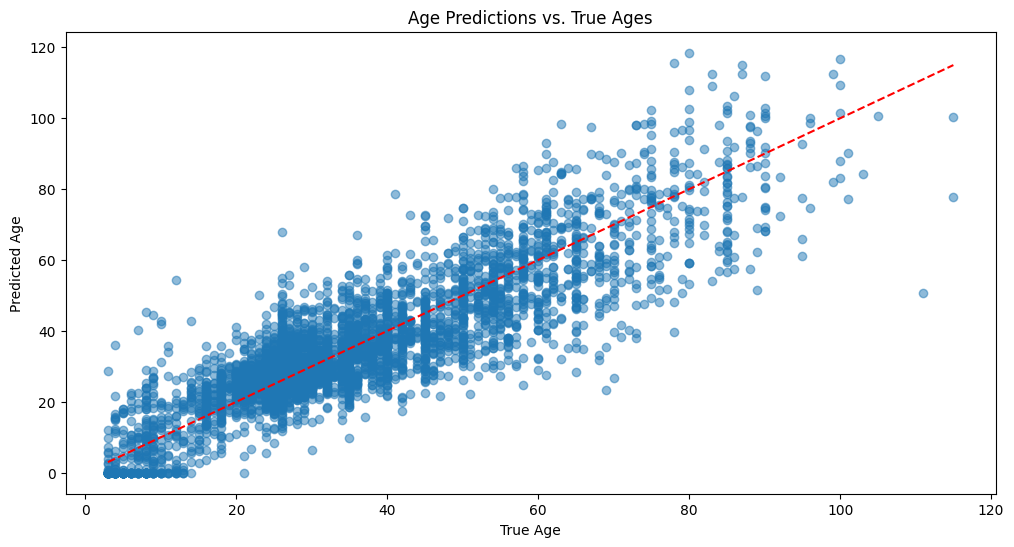

In [22]:
def plot_age_predictions(predictions, labels):
    plt.figure(figsize=(12, 6))
    plt.scatter(labels, predictions, alpha=0.5)
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.title('Age Predictions vs. True Ages')
    plt.plot([min(labels), max(labels)], [min(labels), max(labels)], color='red', linestyle='--') 
    plt.show()

def plot_sample_images(images, age_preds, age_labels, gender_preds, gender_labels):
    num_samples = min(len(images), 5) 
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = images[i].transpose(0, 2, 1) 
        plt.imshow(img)
        plt.title(f"Age: {age_labels[i]:.1f}\nPred: {age_preds[i]:.1f}\nGender: {gender_labels[i]}\nPred: {gender_preds[i]}")
        plt.axis('off')
    plt.show()

plot_age_predictions(all_age_outputs, all_age_labels)

The contrast between predicted and true ages show us a lot of overlap. We can see that the model is thus showing promising reuslts for predicting the age.

Confusion Matrix:
[[2056  249]
 [ 153 1962]]


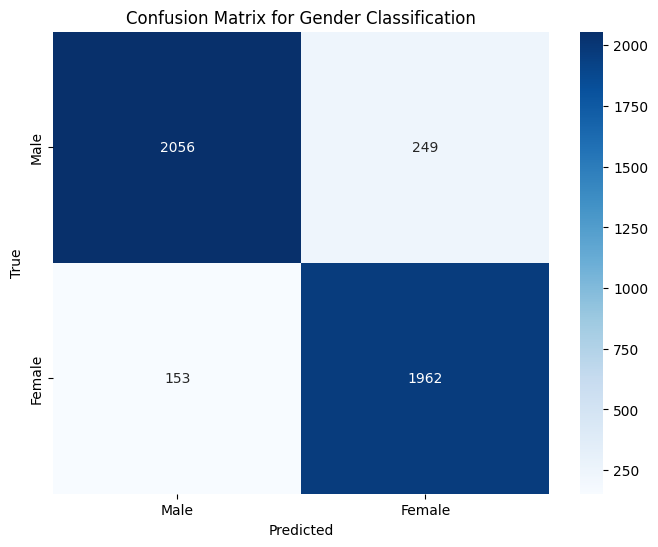

Classification Report:
              precision    recall  f1-score   support

        Male       0.93      0.89      0.91      2305
      Female       0.89      0.93      0.91      2115

    accuracy                           0.91      4420
   macro avg       0.91      0.91      0.91      4420
weighted avg       0.91      0.91      0.91      4420



In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_gender_performance(predictions, labels):
    cm = confusion_matrix(labels, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix for Gender Classification')
    plt.show()

    report = classification_report(labels, predictions, target_names=['Male', 'Female'])
    print("Classification Report:")
    print(report)

evaluate_gender_performance(all_gender_outputs, all_gender_labels)

**Accuracy:** The model achieved an overall accuracy of 91%, indicating strong performance in distinguishing between male and female categories.

**Precision and Recall:**

Male: Precision is high at 93%, meaning that when the model predicts "Male," it is correct 93% of the time. Recall is slightly lower at 89%, meaning the model identifies 89% of all actual males.
Female: Precision is at 89%, and recall is higher at 93%, showing the model is effective at identifying most actual females, though with slightly more false positives.

**F1-Score:** The F1-scores are balanced and at 0.91 for both categories, reflecting a good trade-off between precision and recall.

Overall, the model performs well with a slight trade-off between precision and recall for male and female predictions.

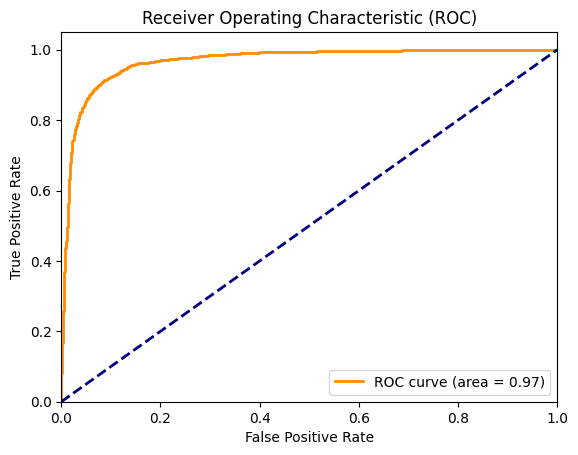

In [24]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(labels, predictions):
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

def get_gender_probabilities(model, dataloader):
    model.eval()
    all_gender_probs = []
    all_gender_labels = []
    
    with torch.no_grad():
        for images, _, genders in dataloader:
            images = images.to(device)
            genders = genders.to(device).long()
            
            _, gender_outputs = model(images)
            gender_probs = torch.softmax(gender_outputs, dim=1)[:, 1].cpu().numpy()
            all_gender_probs.extend(gender_probs)
            all_gender_labels.extend(genders.cpu().numpy())
    
    return np.array(all_gender_probs), np.array(all_gender_labels)

gender_probs, gender_labels = get_gender_probabilities(model, test_loader)
plot_roc_curve(gender_labels, gender_probs)

For the ROC AUC curve, we can see that the model is performing very well, with a 0.97 score. 

This means that the model is very effective at distinguishing between male and female categories.

# Model interpretability

Let's start by looking at some of the predictions that our model is doing. We will check bad and good predictions first.

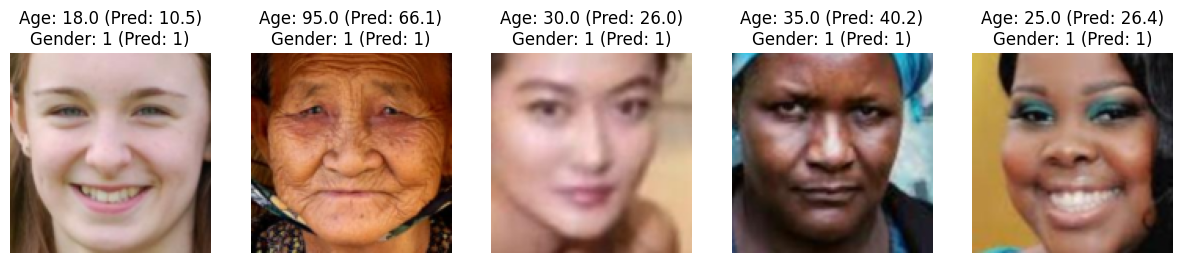

In [25]:
def plot_sample_images(images, age_preds, age_labels, gender_preds, gender_labels, num_samples=5):
    num_samples = min(len(images), num_samples) 
    plt.figure(figsize=(15, 10))
    
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = images[i].transpose(1, 2, 0)  
        plt.imshow(img)
        plt.title(f"Age: {age_labels[i]:.1f} (Pred: {age_preds[i]:.1f})\nGender: {gender_labels[i]} (Pred: {gender_preds[i]})")
        plt.axis('off')
    
    plt.show()

plot_sample_images(all_images, all_age_outputs, all_age_labels, all_gender_outputs, all_gender_labels)

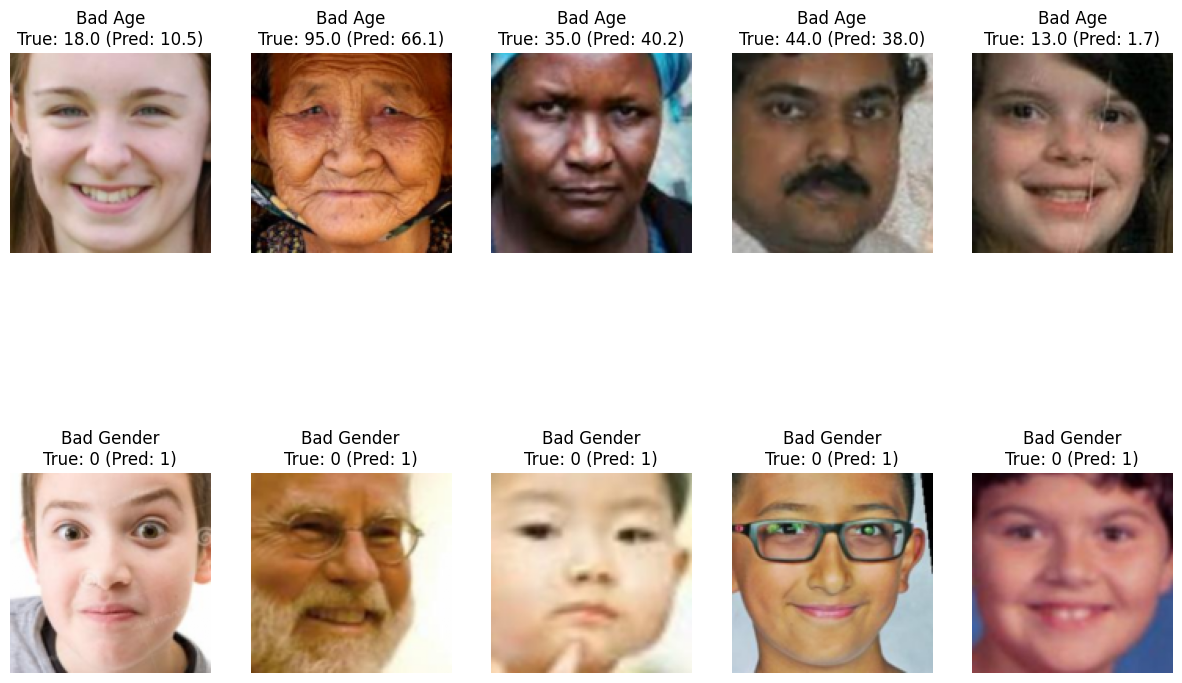

In [26]:
def find_bad_predictions(age_preds, age_labels, gender_preds, gender_labels, age_threshold=5.0):
    age_errors = np.abs(age_preds - age_labels)
    bad_age_indices = np.where(age_errors > age_threshold)[0]

    gender_errors = (gender_preds != gender_labels)
    bad_gender_indices = np.where(gender_errors)[0]

    return bad_age_indices, bad_gender_indices

def plot_bad_predictions(images, age_preds, age_labels, gender_preds, gender_labels, bad_age_indices, bad_gender_indices, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    num_samples = min(len(bad_age_indices), num_samples)
    for i in range(num_samples):
        idx = bad_age_indices[i]
        plt.subplot(2, num_samples, i + 1)
        img = images[idx].transpose(1, 2, 0)
        plt.imshow(img)
        plt.title(f"Bad Age\nTrue: {age_labels[idx]:.1f} (Pred: {age_preds[idx]:.1f})")
        plt.axis('off')

    num_samples = min(len(bad_gender_indices), num_samples)
    for i in range(num_samples):
        idx = bad_gender_indices[i]
        plt.subplot(2, num_samples, num_samples + i + 1)
        img = images[idx].transpose(1, 2, 0)
        plt.imshow(img)
        plt.title(f"Bad Gender\nTrue: {gender_labels[idx]} (Pred: {gender_preds[idx]})")
        plt.axis('off')

    plt.show()

bad_age_indices, bad_gender_indices = find_bad_predictions(all_age_outputs, all_age_labels, all_gender_outputs, all_gender_labels)
plot_bad_predictions(all_images, all_age_outputs, all_age_labels, all_gender_outputs, all_gender_labels, bad_age_indices, bad_gender_indices)

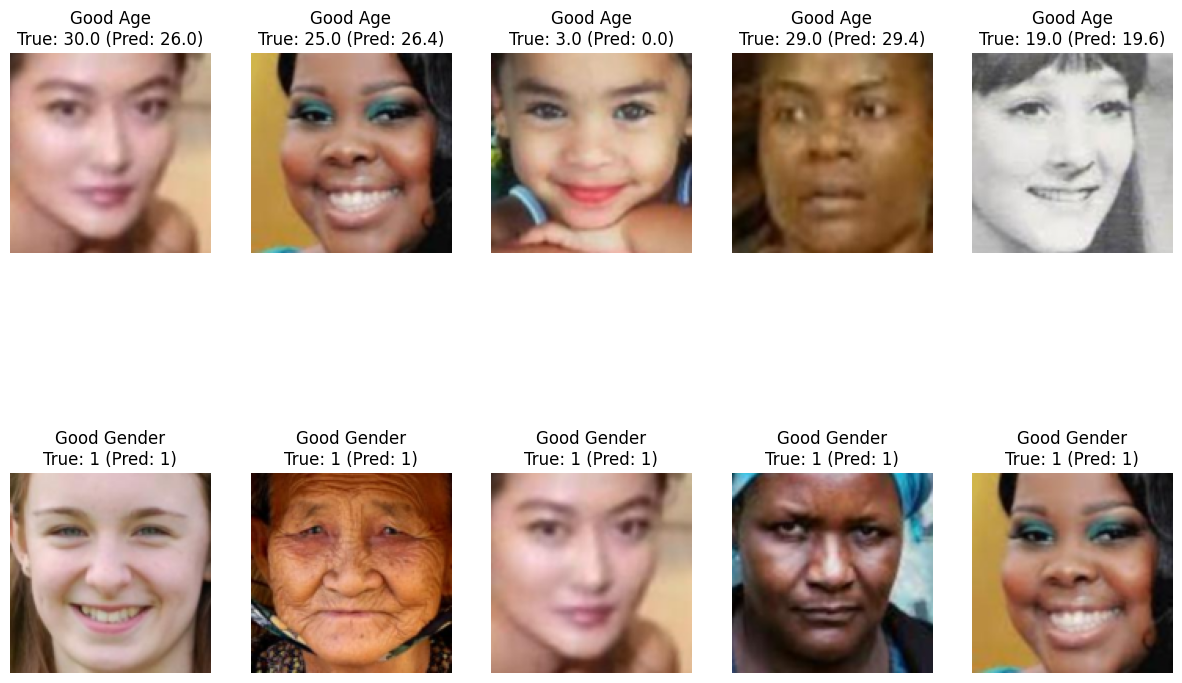

In [27]:
def find_good_predictions(age_preds, age_labels, gender_preds, gender_labels, age_threshold=5.0):
    age_errors = np.abs(age_preds - age_labels)
    good_age_indices = np.where(age_errors <= age_threshold)[0]

    gender_matches = (gender_preds == gender_labels)
    good_gender_indices = np.where(gender_matches)[0]

    return good_age_indices, good_gender_indices

def plot_good_predictions(images, age_preds, age_labels, gender_preds, gender_labels, good_age_indices, good_gender_indices, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    num_samples = min(len(good_age_indices), num_samples)
    for i in range(num_samples):
        idx = good_age_indices[i]
        plt.subplot(2, num_samples, i + 1)
        img = images[idx].transpose(1, 2, 0) 
        plt.imshow(img)
        plt.title(f"Good Age\nTrue: {age_labels[idx]:.1f} (Pred: {age_preds[idx]:.1f})")
        plt.axis('off')

    num_samples = min(len(good_gender_indices), num_samples)
    for i in range(num_samples):
        idx = good_gender_indices[i]
        plt.subplot(2, num_samples, num_samples + i + 1)
        img = images[idx].transpose(1, 2, 0) 
        plt.imshow(img)
        plt.title(f"Good Gender\nTrue: {gender_labels[idx]} (Pred: {gender_preds[idx]})")
        plt.axis('off')

    plt.show()

good_age_indices, good_gender_indices = find_good_predictions(all_age_outputs, all_age_labels, all_gender_outputs, all_gender_labels)
plot_good_predictions(all_images, all_age_outputs, all_age_labels, all_gender_outputs, all_gender_labels, good_age_indices, good_gender_indices)

Now let's check the best and worst predictions that our model has made

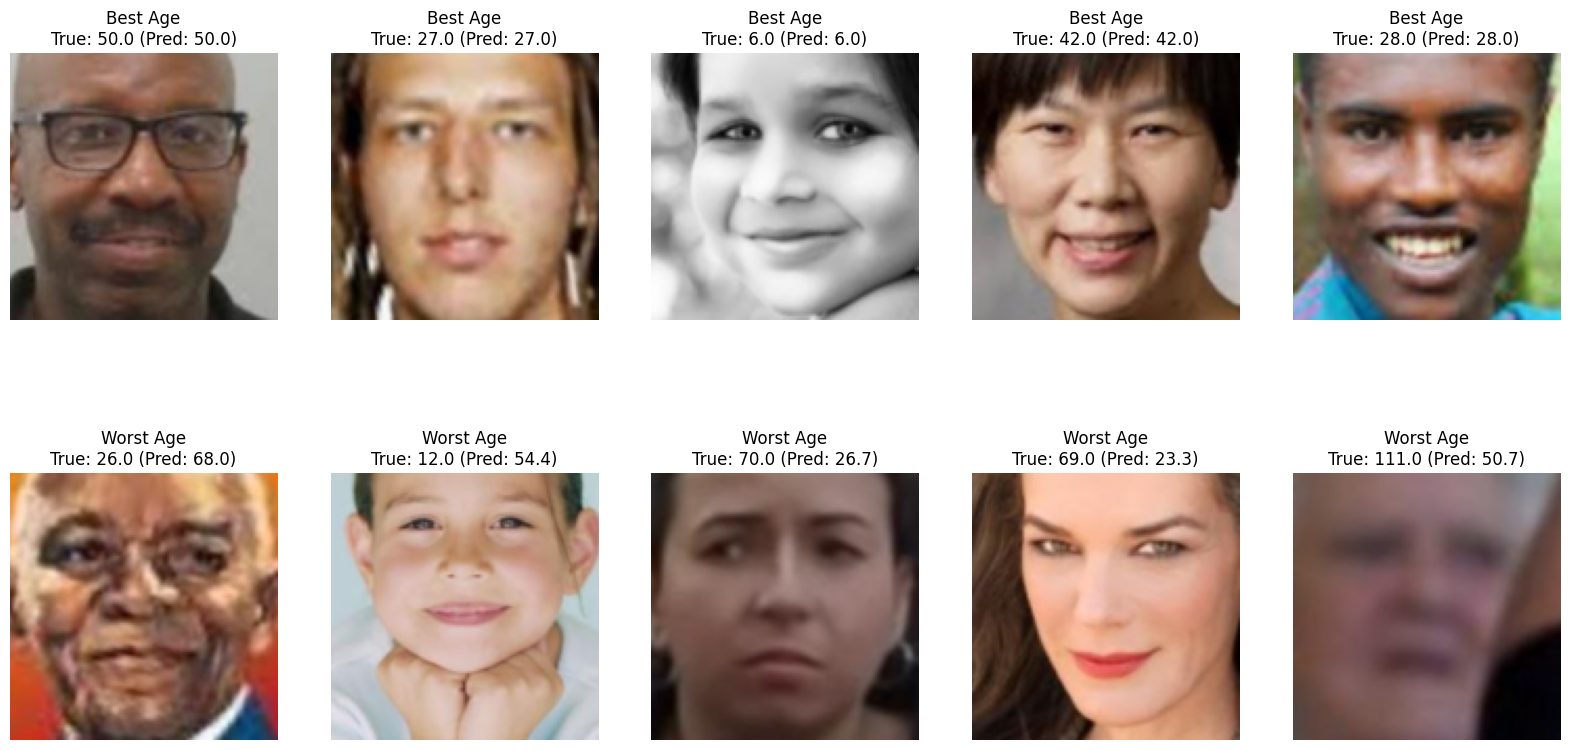

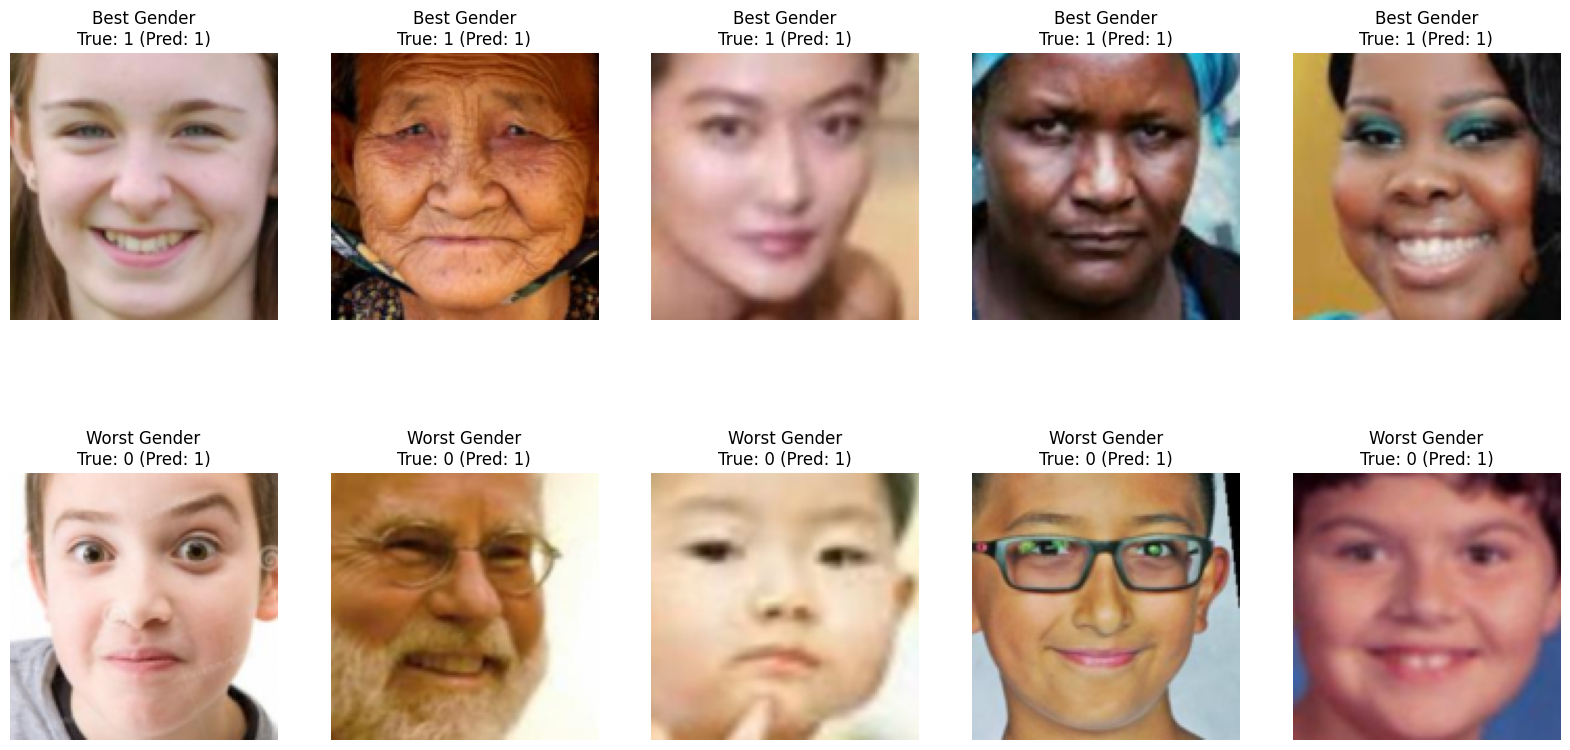

In [28]:
def find_best_worst_predictions(age_preds, age_labels, gender_preds, gender_labels, num_samples=5):
    age_errors = np.abs(age_preds - age_labels)

    best_age_indices = np.argsort(age_errors)[:num_samples]
    worst_age_indices = np.argsort(age_errors)[-num_samples:]

    gender_matches = (gender_preds == gender_labels)
    correct_gender_indices = np.where(gender_matches)[0]
    incorrect_gender_indices = np.where(~gender_matches)[0]

    best_gender_indices = correct_gender_indices[:num_samples]
    worst_gender_indices = incorrect_gender_indices[:num_samples]

    return best_age_indices, worst_age_indices, best_gender_indices, worst_gender_indices

def plot_best_worst_predictions(images, age_preds, age_labels, gender_preds, gender_labels, best_age_indices, worst_age_indices, best_gender_indices, worst_gender_indices):
    plt.figure(figsize=(20, 10))
    
    for i in range(len(best_age_indices)):
        idx = best_age_indices[i]
        plt.subplot(2, len(best_age_indices), i + 1)
        img = images[idx].transpose(1, 2, 0) 
        plt.imshow(img)
        plt.title(f"Best Age\nTrue: {age_labels[idx]:.1f} (Pred: {age_preds[idx]:.1f})")
        plt.axis('off')

    for i in range(len(worst_age_indices)):
        idx = worst_age_indices[i]
        plt.subplot(2, len(worst_age_indices), len(best_age_indices) + i + 1)
        img = images[idx].transpose(1, 2, 0) 
        plt.imshow(img)
        plt.title(f"Worst Age\nTrue: {age_labels[idx]:.1f} (Pred: {age_preds[idx]:.1f})")
        plt.axis('off')

    plt.figure(figsize=(20, 10))
    
    for i in range(len(best_gender_indices)):
        idx = best_gender_indices[i]
        plt.subplot(2, len(best_gender_indices), i + 1)
        img = images[idx].transpose(1, 2, 0)
        plt.imshow(img)
        plt.title(f"Best Gender\nTrue: {gender_labels[idx]} (Pred: {gender_preds[idx]})")
        plt.axis('off')

    for i in range(len(worst_gender_indices)):
        idx = worst_gender_indices[i]
        plt.subplot(2, len(worst_gender_indices), len(best_gender_indices) + i + 1)
        img = images[idx].transpose(1, 2, 0) 
        plt.imshow(img)
        plt.title(f"Worst Gender\nTrue: {gender_labels[idx]} (Pred: {gender_preds[idx]})")
        plt.axis('off')

    plt.show()

best_age_indices, worst_age_indices, best_gender_indices, worst_gender_indices = find_best_worst_predictions(all_age_outputs, all_age_labels, all_gender_outputs, all_gender_labels)
plot_best_worst_predictions(all_images, all_age_outputs, all_age_labels, all_gender_outputs, all_gender_labels, best_age_indices, worst_age_indices, best_gender_indices, worst_gender_indices)

Unfortunately, we can see that some images we are showing are not even images of real people. This can happen with such a large dataset, and even after manual cleaning. 

Besides that, some of the images we are showing have very good predictions from our model, and some others have poor predictions. Overall, the model is performing quite well.

In [29]:
def calculate_within_range_percentage(age_preds, age_labels, range_threshold=5):
    age_errors = np.abs(age_preds - age_labels)
    within_range = age_errors <= range_threshold
    percentage_within_range = np.mean(within_range) * 100
    return percentage_within_range, within_range 

In [30]:
percentage_within_range, within_range = calculate_within_range_percentage(np.array(all_age_outputs), np.array(all_age_labels), range_threshold=5)

print(f"Percentage of predictions within ±5 years: {percentage_within_range:.2f}%")

Percentage of predictions within ±5 years: 49.50%


Our model is predicting around half of the people's age within 5 years of their actual age. For a starting point, this is a pretty good indication that our model is working well.

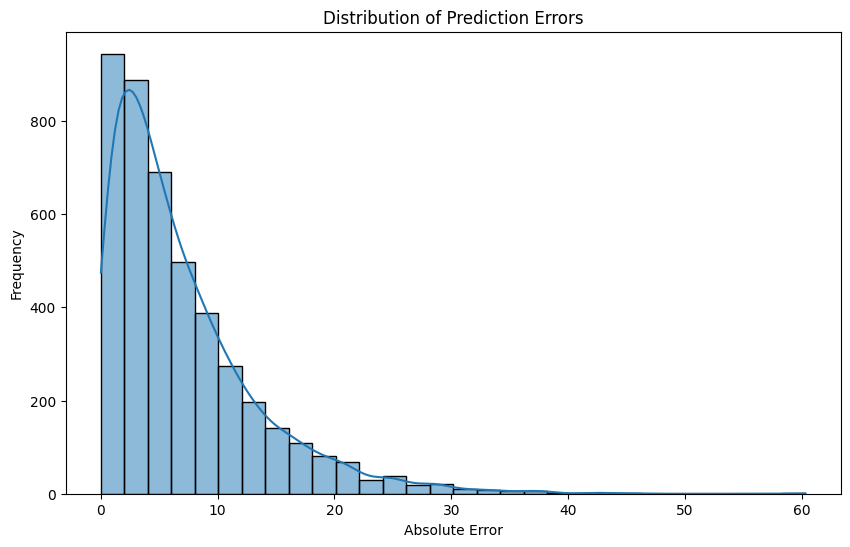

In [31]:
def plot_error_distribution(age_preds, age_labels):
    age_errors = np.abs(age_preds - age_labels)
    plt.figure(figsize=(10, 6))
    sns.histplot(age_errors, bins=30, kde=True)
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.show()
    
plot_error_distribution(all_age_outputs, all_age_labels)

In [32]:
def evaluate_by_age_range(age_preds, age_labels, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]):
    age_bins = np.digitize(age_labels, bins, right=True)
    for bin in np.unique(age_bins):
        bin_indices = np.where(age_bins == bin)[0]
        if bin_indices.size > 0:
            bin_preds = age_preds[bin_indices]
            bin_labels = age_labels[bin_indices]
            mae = np.mean(np.abs(bin_preds - bin_labels))
            if bin < len(bins) - 1:
                print(f"Age Range {bins[bin-1]}-{bins[bin]}: MAE = {mae:.2f}")
            else:
                print(f"Age Range {bins[bin-1]}+: MAE = {mae:.2f}")
        
evaluate_by_age_range(all_age_outputs, all_age_labels)

Age Range 0-10: MAE = 6.37
Age Range 10-20: MAE = 6.68
Age Range 20-30: MAE = 4.74
Age Range 30-40: MAE = 6.01
Age Range 40-50: MAE = 8.37
Age Range 50-60: MAE = 9.54
Age Range 60-70: MAE = 12.08
Age Range 70-80: MAE = 13.24
Age Range 80-90: MAE = 13.13
Age Range 90+: MAE = 14.10
Age Range 100+: MAE = 24.22


The results of the Mean Absolute Error for each age range are widely varied. There is indeed a big difference between the MAE for the high age ranges (60 to 100, where it averages around 13-14) and those for younger ones, where it even goes down to 4.74 for the age range 20 to 30.

This is an interesting result, as it shows that our model is able to predict the age of people with fewer errors when the person in question is within a certain age range.

In [33]:
def check_fairness(age_preds, age_labels, gender_labels):
    from sklearn.metrics import mean_absolute_error
    male_indices = np.where(gender_labels == 0)[0]
    female_indices = np.where(gender_labels == 1)[0]
    
    mae_male = mean_absolute_error(age_preds[male_indices], age_labels[male_indices])
    mae_female = mean_absolute_error(age_preds[female_indices], age_labels[female_indices])
    
    print(f"MAE for Males: {mae_male:.2f}")
    print(f"MAE for Females: {mae_female:.2f}")

check_fairness(all_age_outputs, all_age_labels, all_gender_labels)

MAE for Males: 7.08
MAE for Females: 6.77


The Mean Absolute Error for Males is 7.08, and the Mean Absolute Error for Females is 6.77. This means that the model is more accurate in predicting the age of females than males, even if by a very narrow margin.

Suppose we're a company that uses the age prediction model to customize products or services based on age. Errors in predictions could lead to financial setbacks, such as:

- Incorrect Customization Costs: If our model predicts the age incorrectly, customers might receive products or services that do not match their preferences, leading to returns or dissatisfaction. This could cost the company an average of $10 per incorrect prediction due to returns, restocking fees, or loss of customer trust.

- Operational Costs: Handling incorrect predictions might involve additional customer service resources, leading to increased operational costs.

Let's see how, in economical terms, this would affect us.

In [34]:
def cost_benefit_analysis(age_preds, age_labels, cost_per_error=10):
    "Define cost-benefit analysis"
    errors = np.abs(age_preds - age_labels)
    total_cost = np.sum(errors) * cost_per_error
    average_cost_per_prediction = total_cost / len(age_preds)
    print(f"Total Cost of Errors: ${total_cost:.2f}")
    print(f"Average Cost per Prediction: ${average_cost_per_prediction:.2f}")

cost_benefit_analysis(all_age_outputs, all_age_labels)

Total Cost of Errors: $306512.03
Average Cost per Prediction: $69.35


In our super simple hypothetical scenario, we can see that getting a prediction wrong is quite expensive. Because the total price would be 69.35 (the price for one prediction), plus 10 for each incorrect prediction. 

This all sums up, for our dataset, to a total of $306512.03 lost due to incorrect predictions.

# Checking model interpretability with LIME

We now want to understand better how the model is working under the hood. To do this, we can use SHAP and LIME to explain the model's predictions.

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

def batch_predict(images):
    model.eval()
    images = torch.stack([transform(image).to(device) for image in images], dim=0)
    with torch.no_grad():
        age_outputs, gender_outputs = model(images)
    return gender_outputs.cpu().numpy()

explainer = lime_image.LimeImageExplainer()


idx = 0 
image = all_images[idx].transpose(1, 2, 0)
true_gender_label = all_gender_labels[idx]
predicted_gender_label = all_gender_outputs[idx]

if image.dtype != np.uint8:
    image = (image * 255).astype(np.uint8)

explanation = explainer.explain_instance(image, batch_predict, top_labels=2, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(predicted_gender_label, positive_only=True, num_features=10, hide_rest=False)
img_boundry1 = mark_boundaries(temp, mask)

plt.figure(figsize=(8, 8))
plt.title(f'Explanation for Predicted Gender Class {predicted_gender_label} (True Label: {true_gender_label})')
plt.imshow(img_boundry1)
plt.axis('off')
plt.show()

C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = row[0]
C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_gender_label = row[2]  # Assuming the gender label is in the 3rd column


Ethnicity: White, Gender: Male


100%|██████████| 1000/1000 [00:08<00:00, 124.37it/s]


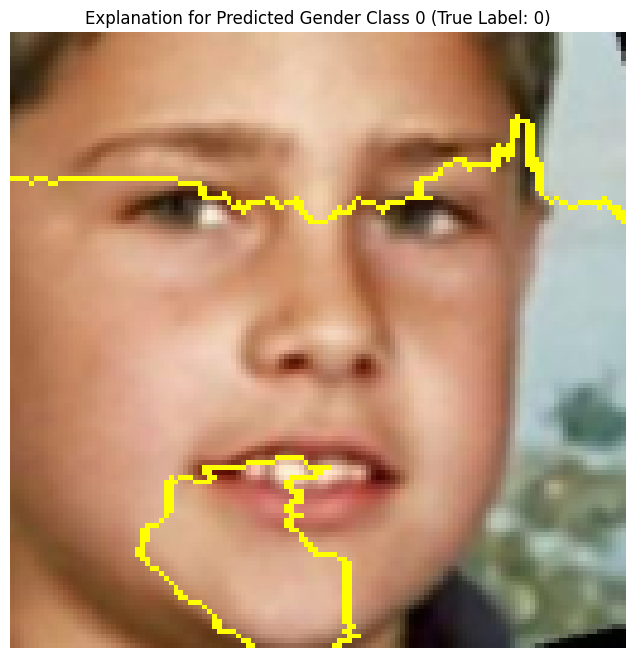

C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = row[0]
C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_gender_label = row[2]  # Assuming the gender label is in the 3rd column


Ethnicity: White, Gender: Female


100%|██████████| 1000/1000 [00:07<00:00, 126.68it/s]


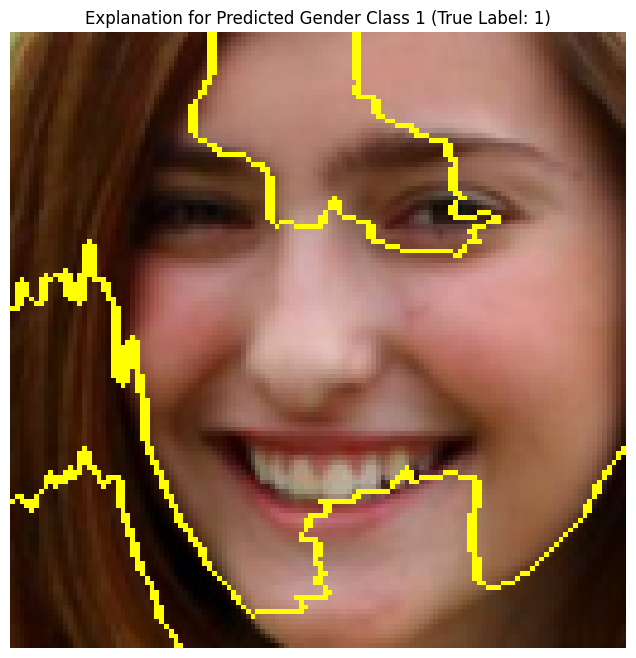

C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = row[0]
C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_gender_label = row[2]  # Assuming the gender label is in the 3rd column


Ethnicity: Black, Gender: Male


100%|██████████| 1000/1000 [00:07<00:00, 125.03it/s]


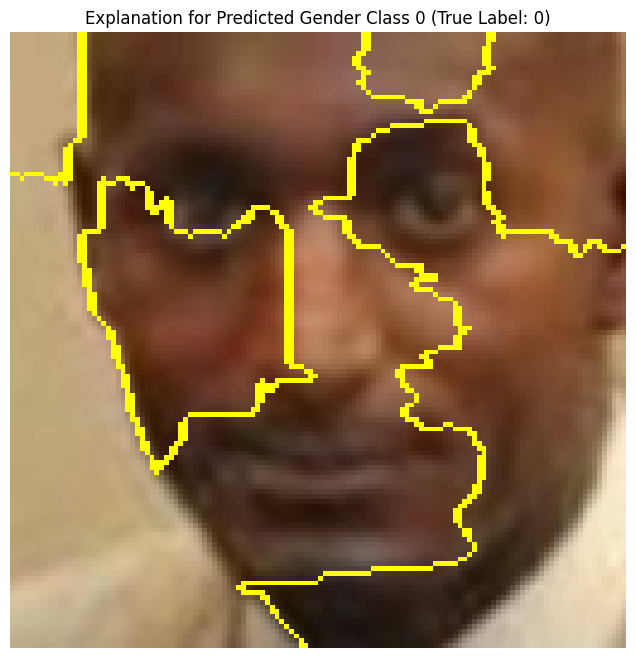

C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = row[0]
C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_gender_label = row[2]  # Assuming the gender label is in the 3rd column


Ethnicity: Black, Gender: Female


100%|██████████| 1000/1000 [00:08<00:00, 122.73it/s]


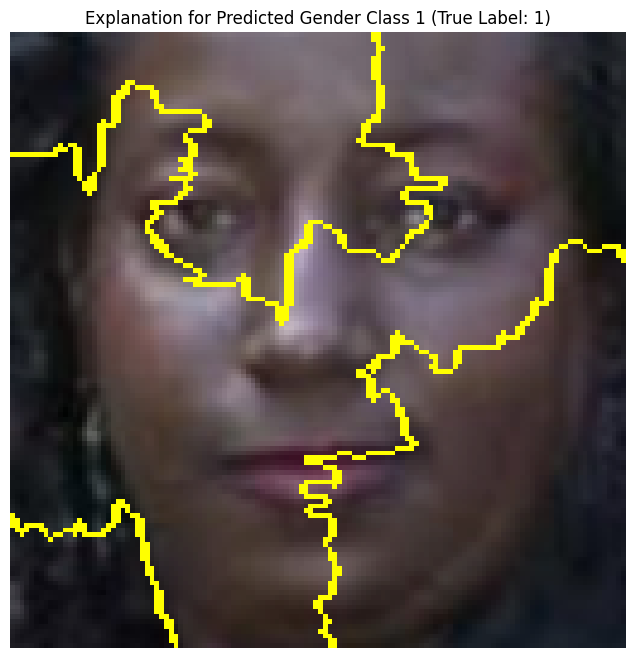

C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = row[0]
C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_gender_label = row[2]  # Assuming the gender label is in the 3rd column


Ethnicity: Asian, Gender: Male


100%|██████████| 1000/1000 [00:08<00:00, 120.81it/s]


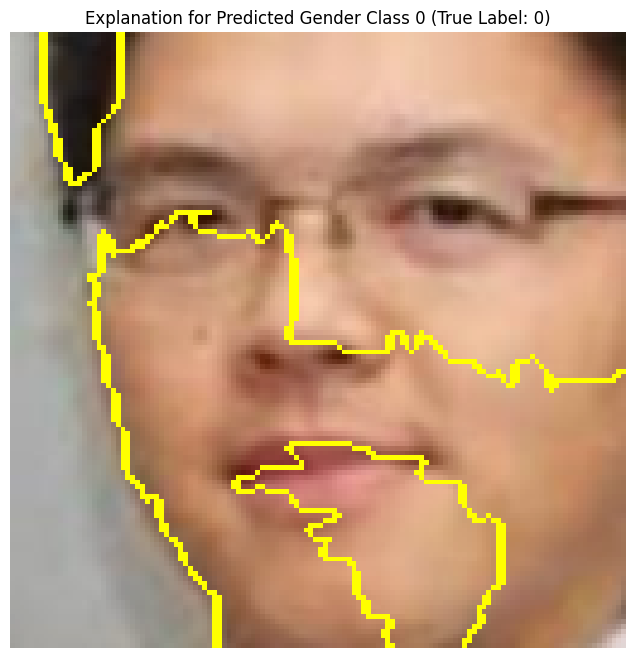

C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = row[0]
C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_gender_label = row[2]  # Assuming the gender label is in the 3rd column


Ethnicity: Asian, Gender: Female


100%|██████████| 1000/1000 [00:08<00:00, 119.35it/s]


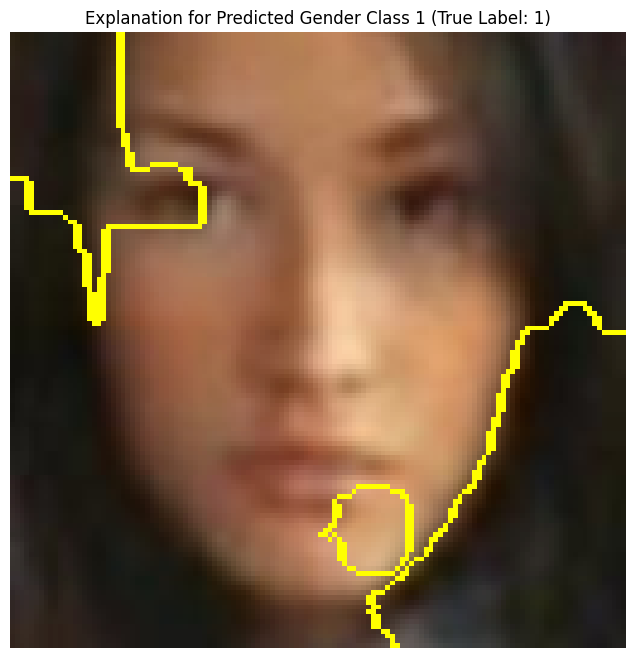

C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = row[0]
C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_gender_label = row[2]  # Assuming the gender label is in the 3rd column


Ethnicity: Indian, Gender: Male


100%|██████████| 1000/1000 [00:09<00:00, 107.83it/s]


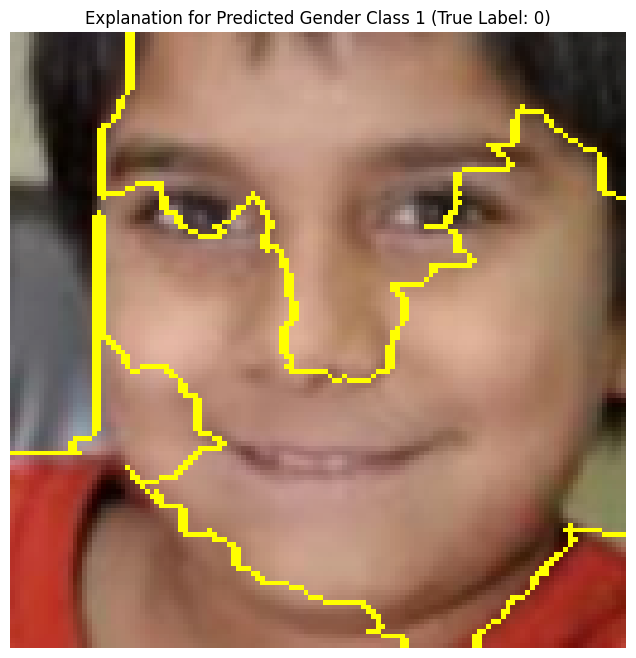

C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = row[0]
C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_gender_label = row[2]  # Assuming the gender label is in the 3rd column


Ethnicity: Indian, Gender: Female


100%|██████████| 1000/1000 [00:08<00:00, 115.97it/s]


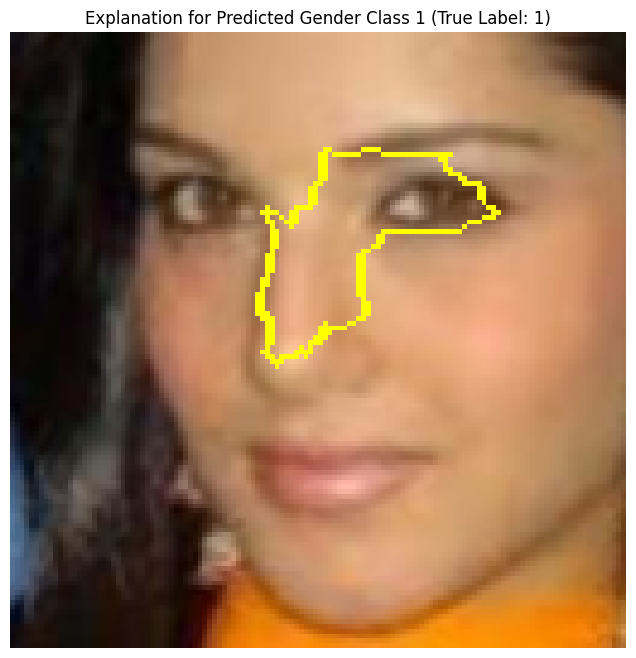

C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = row[0]
C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_gender_label = row[2]  # Assuming the gender label is in the 3rd column


Ethnicity: Others, Gender: Male


100%|██████████| 1000/1000 [00:08<00:00, 117.03it/s]


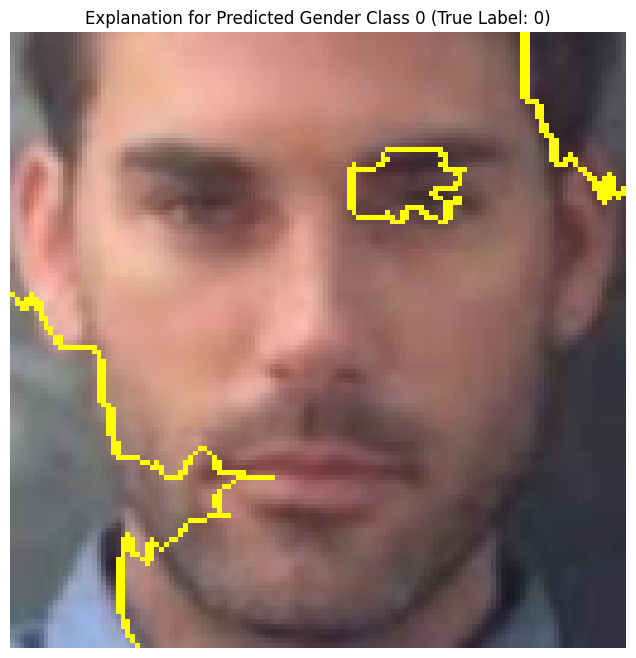

C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = row[0]
C:\Users\ITNESALE\AppData\Local\Temp\ipykernel_10064\2218434570.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_gender_label = row[2]  # Assuming the gender label is in the 3rd column


Ethnicity: Others, Gender: Female


100%|██████████| 1000/1000 [00:08<00:00, 124.04it/s]


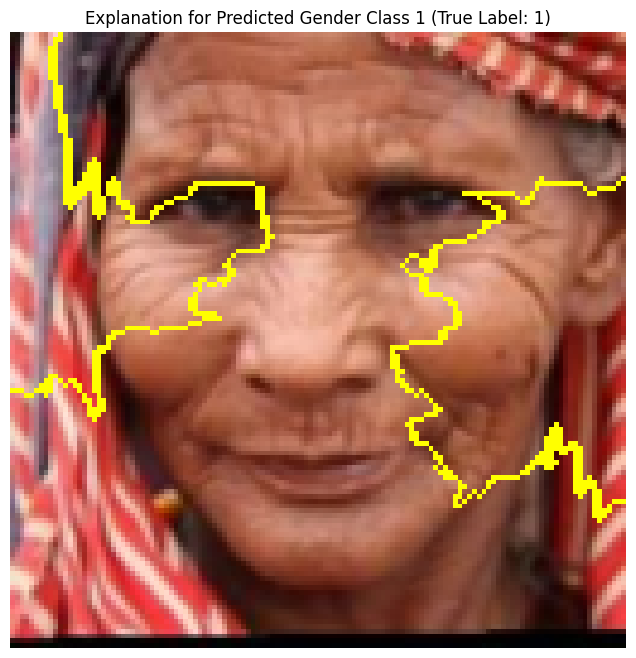

In [38]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import cv2

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

def batch_predict(images):
    model.eval()
    images = torch.stack([transform(image).to(device) for image in images], dim=0)
    with torch.no_grad():
        age_outputs, gender_outputs = model(images)
    return gender_outputs.cpu().numpy()

explainer = lime_image.LimeImageExplainer()

def get_gender_ethnicity_samples(images_data, ethnicity_id, gender_id, num_samples=1):
    samples = images_data[(images_data['ethnicity'] == ethnicity_id) & (images_data['gender'] == gender_id)]
    sample_images = samples.head(num_samples)
    return sample_images

ethnicity_gender_samples = {
    (ethnicity_id, gender_id): get_gender_ethnicity_samples(images_data, ethnicity_id, gender_id)
    for ethnicity_id in ethnicity_mapping.keys()
    for gender_id in gender_mapping.keys()
}

for (ethnicity_id, gender_id), samples in ethnicity_gender_samples.items():
    if not samples.empty:
        print(f"Ethnicity: {ethnicity_mapping[ethnicity_id]}, Gender: {gender_mapping[gender_id]}")
        for idx, row in samples.iterrows():
            img_path = row[0]
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            true_gender_label = row[2] 
            image_transformed = transform(image).numpy().transpose(1, 2, 0)  
            
            if image_transformed.dtype != np.uint8:
                image_transformed = (image_transformed * 255).astype(np.uint8)

            image_tensor = transform(image).unsqueeze(0).to(device)
            with torch.no_grad():
                _, gender_outputs = model(image_tensor)
            predicted_gender_label = torch.argmax(gender_outputs, dim=1).item()

            explanation = explainer.explain_instance(image_transformed, batch_predict, top_labels=2, hide_color=0, num_samples=1000)

            temp, mask = explanation.get_image_and_mask(predicted_gender_label, positive_only=True, num_features=10, hide_rest=False)
            img_boundry = mark_boundaries(temp, mask)

            plt.figure(figsize=(8, 8))
            plt.title(f'Explanation for Predicted Gender Class {predicted_gender_label} (True Label: {true_gender_label})')
            plt.imshow(img_boundry)
            plt.axis('off')
            plt.show()

To analyze the ethical issues and biases in our age and gender prediction model using the UTKFace dataset, we'll break down the key points and provide insights into potential concerns and solutions.

### Potential Biases and Ethical Issues

#### 1. Data Distribution and Representation Bias
**Observation:** The dataset shows an imbalance in ethnicity distribution, with a majority of the data being from White ethnicity.

**Impact:**
- The model may perform better on majority classes (e.g., White ethnicity) and poorly on underrepresented groups (e.g., Black, Asian, Indian, Others).
- This can lead to unfair and inaccurate predictions for individuals from underrepresented groups, exacerbating existing social biases.

**Solution:**
- Use techniques such as oversampling minority classes or data augmentation to balance the dataset.

#### 2. Age Distribution
**Observation:** The age distribution is skewed, with a high prevalence of data around the 0 to 5 age mark and many ages close to 30.

**Impact:**
- The model may struggle with predicting ages that are less represented in the training data.
- This could result in higher prediction errors for certain age groups, particularly those that are underrepresented, as was shown in the MAE analysis..

**Solution:**
- Apply data normalization techniques or stratified sampling to ensure a more uniform age distribution in the training data.

#### 3. Gender Bias
**Observation:** The gender distribution appears fair, but the model's performance metrics indicate a trade-off between precision and recall for male and female predictions.

**Impact:**
- A slight imbalance in precision and recall indicates that the model might be more accurate for one gender over the other.
- This can lead to unequal treatment based on gender, which is ethically problematic.

**Solution:**
- Implement gender-specific performance monitoring and apply fairness constraints during training to ensure balanced performance across genders.
- Regularly audit the model's performance and adjust training practices to mitigate any emerging biases.

### Analyzing Misclassified Samples

**Observation:** Patterns in misclassified samples can reveal potential ethical concerns and biases in the model.

**Impact:**
- Misclassifications could disproportionately affect certain demographic groups, leading to unfair treatment or misrepresentation.
- Analyzing these patterns helps identify if the model's errors are systemic and biased against particular groups.

**Solution:**
- Perform detailed error analysis to understand the root causes of misclassifications.
- Re-train the model with balanced and diverse data to reduce misclassification rates.

### Model Interpretability

**Observation:** Using LIME for model interpretability helps understand the decision-making process of the model.

**Impact:**
- Interpretability allows for identifying and addressing biased decision-making.
- It provides transparency, which is crucial for ethical AI deployment.

**Solution:**
- Regularly use interpretability tools like LIME to audit the model.
- Ensure that stakeholders understand how the model makes decisions and involve them in the bias mitigation process.

### Deployment Considerations

**Domain Suitability:**
Based on the results from the model that we just saw,

- **Suitable Domains:** Applications where age and gender predictions are used for non-critical purposes, such as demographic analysis in marketing.
- **Unsuitable Domains:** High-stakes applications like hiring, law enforcement, or medical diagnostics, where biases can lead to significant harm or discrimination.

**Recommendations:**
- Before deploying the model, conduct thorough ethical reviews and bias assessments.
- Establish clear guidelines and protocols for the responsible use of the model.
- Continuously monitor and update the model to address any emerging biases.

### Summary

- **Data Representation:** Ensure diverse and balanced data representation to mitigate biases.
- **Model Performance:** Regularly evaluate and audit model performance across different demographic groups.
- **Interpretability and Transparency:** Use interpretability tools to understand and address biased decision-making.
- **Ethical Deployment:** Carefully consider the ethical implications and suitability of deploying the model in various domains.

By following these guidelines, we can build a more fair, accurate, and ethically sound age and gender prediction model.

In [39]:
torch.save(model, 'age_gender_model')